In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib import urlretrieve
import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

ImportError: cannot import name gof

In [3]:
def load_dataset():
    url = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
    filename = 'mnist.pkl.gz'
    if not os.path.exists(filename):
        print("Downloading MNIST dataset...")
        urlretrieve(url, filename)
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    X_train, y_train = data[0]
    X_val, y_val = data[1]
    X_test, y_test = data[2]
    X_train = X_train.reshape((-1, 1, 28, 28))
    X_val = X_val.reshape((-1, 1, 28, 28))
    X_test = X_test.reshape((-1, 1, 28, 28))
    y_train = y_train.astype(np.uint8)
    y_val = y_val.astype(np.uint8)
    y_test = y_test.astype(np.uint8)
    return X_train, y_train, X_val, y_val, X_test, y_test

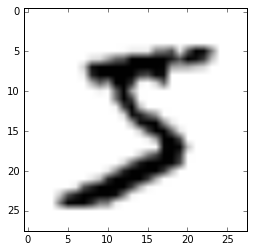

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
plt.imshow(X_train[0][0], cmap=cm.binary)

In [5]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 28, 28),
    # layer conv2d1
    conv2d1_num_filters=32,
    conv2d1_filter_size=(5, 5),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),  
    # layer maxpool1
    maxpool1_pool_size=(2, 2),    
    # layer conv2d2
    conv2d2_num_filters=32,
    conv2d2_filter_size=(5, 5),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,    
    # dense
    dense_num_units=256,
    dense_nonlinearity=lasagne.nonlinearities.rectify,    
    # dropout2
    dropout2_p=0.5,    
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=10,
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=10,
    verbose=1,
    )
# Train the network
nn = net1.fit(X_train, y_train)

# Neural Network with 160362 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x28x28
  1  conv2d1   32x24x24
  2  maxpool1  32x12x12
  3  conv2d2   32x8x8
  4  maxpool2  32x4x4
  5  dropout1  32x4x4
  6  dense     256
  7  dropout2  256
  8  output    10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.85736     0.16550    5.18040      0.95082  72.17s
      2     0.26053     0.10713    2.43182      0.96942  80.33s
      3     0.19326     0.08436    2.29083      0.97491  66.74s
      4     0.15991     0.07226    2.21315      0.97901  72.80s
      5     0.13773     0.06504    2.11751      0.98111  74.96s
      6     0.12602     0.06049    2.08322      0.98281  63.11s
      7     0.11192     0.05275    2.12189      0.98451  63.31s
      8     0.10269     0.05032    2.04077      0.98451  63.04s
      9     0.09628     0.04635    2.07699      0.98

In [6]:
preds = net1.predict(X_test)

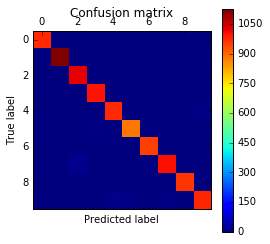

In [7]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<module 'matplotlib.pyplot' from '/Users/michellechen/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

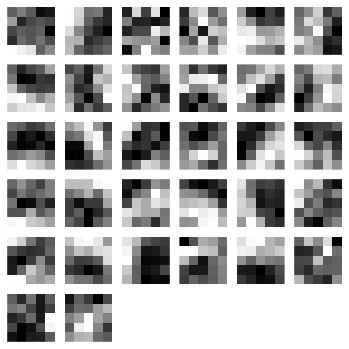

In [8]:
visualize.plot_conv_weights(net1.layers_['conv2d1'])

/Users/michellechen/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<module 'matplotlib.pyplot' from '/Users/michellechen/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

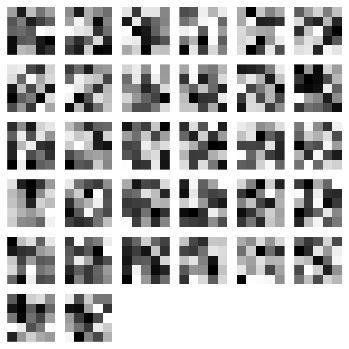

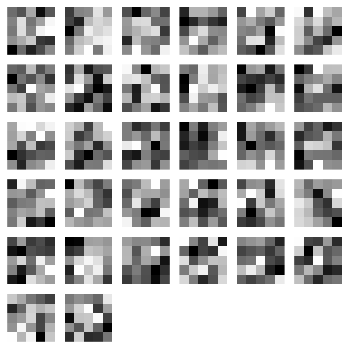

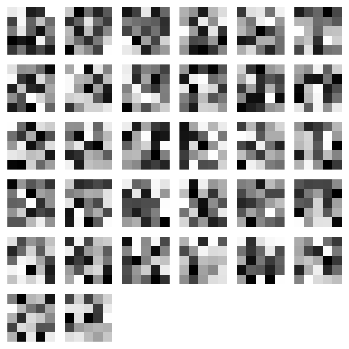

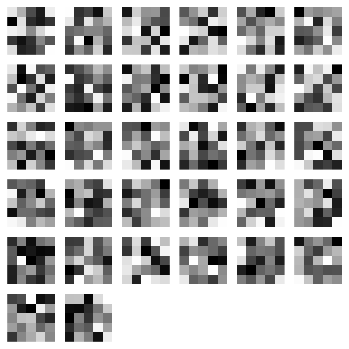

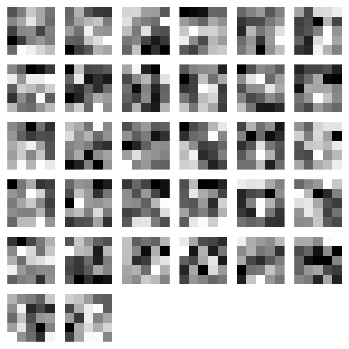

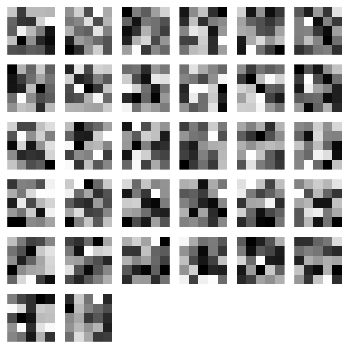

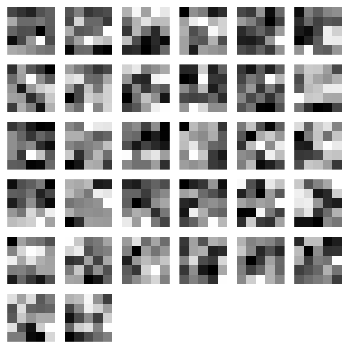

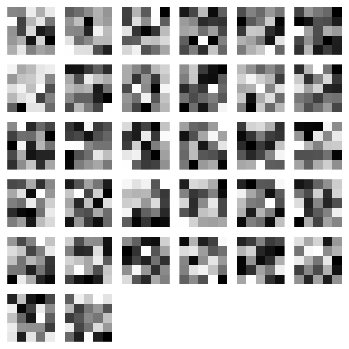

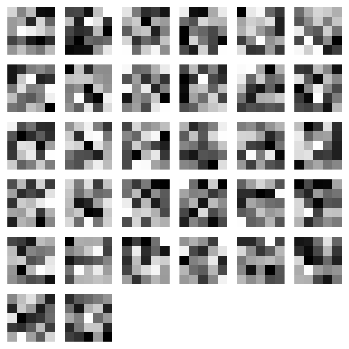

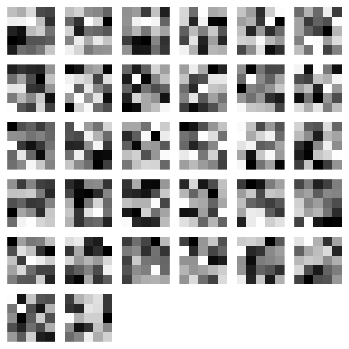

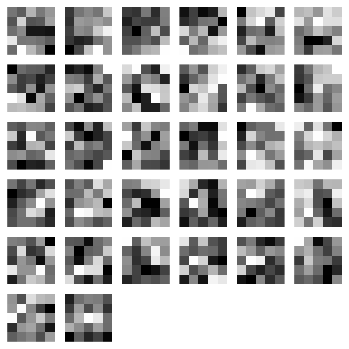

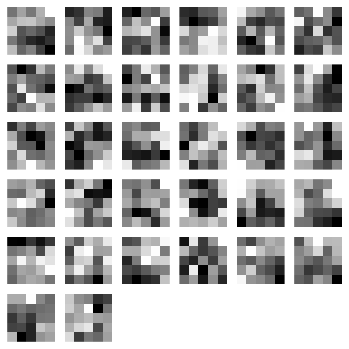

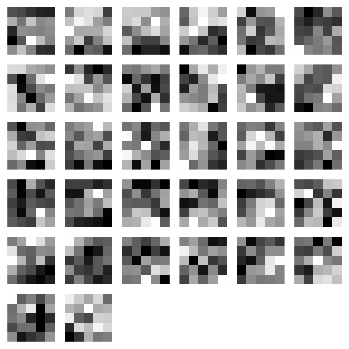

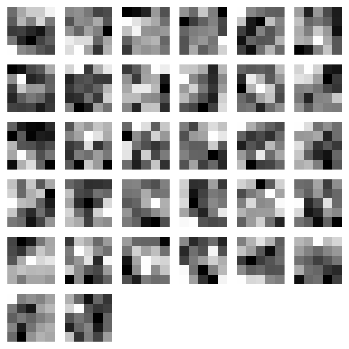

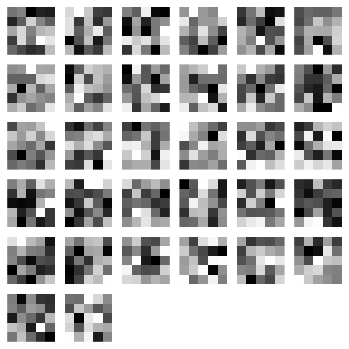

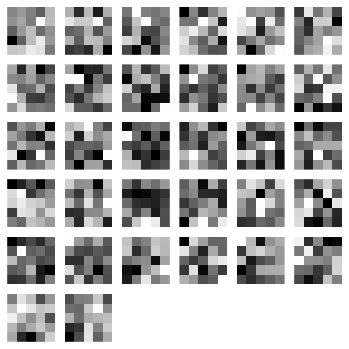

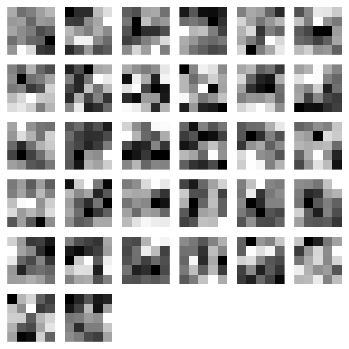

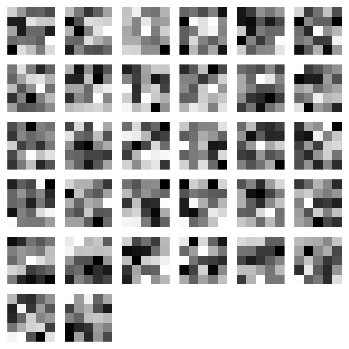

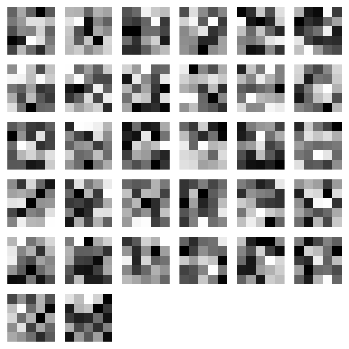

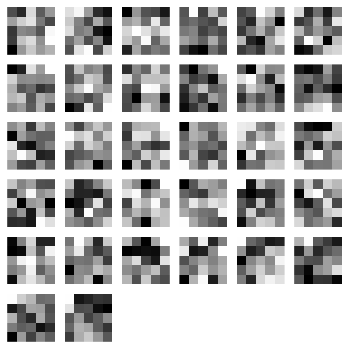

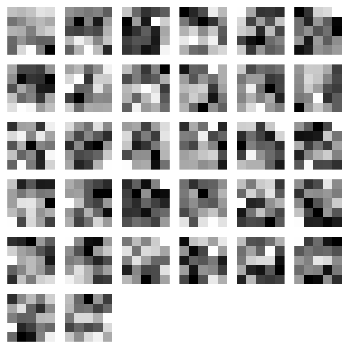

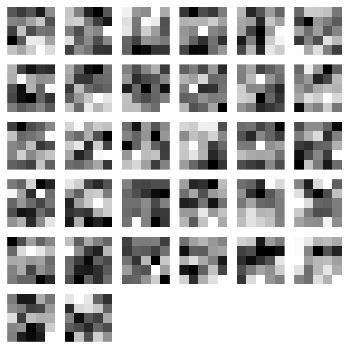

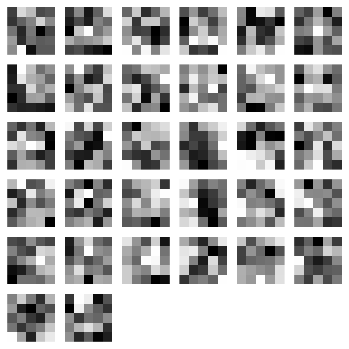

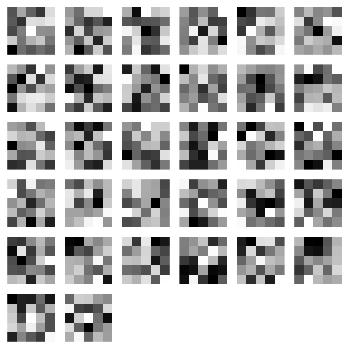

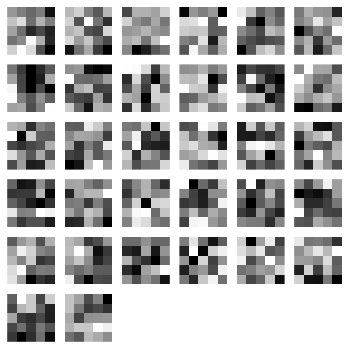

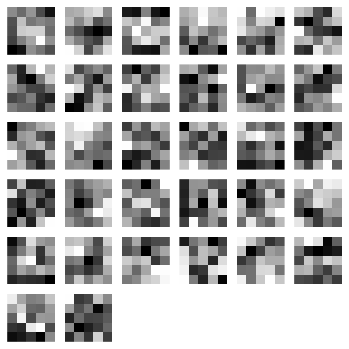

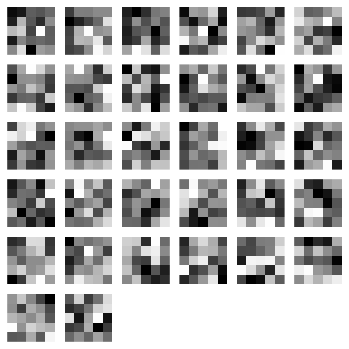

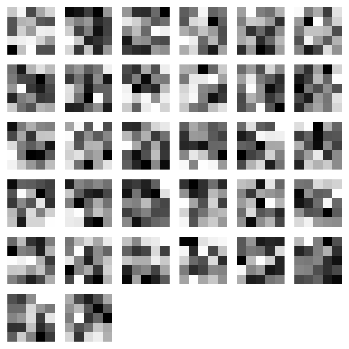

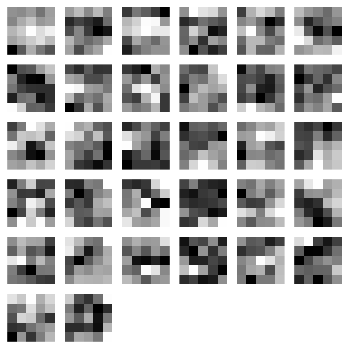

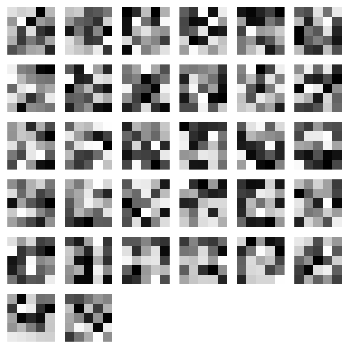

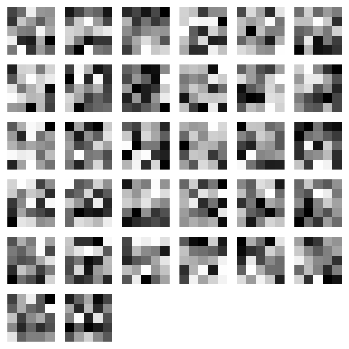

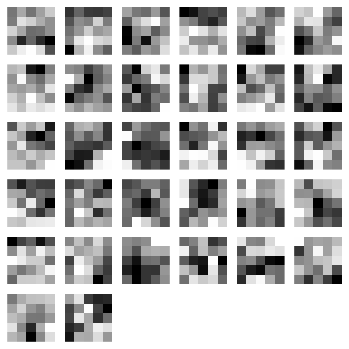

In [15]:
visualize.plot_conv_weights(net1.layers_['conv2d2'])

In [9]:
dense_layer = layers.get_output(net1.layers_['dense'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
input_var = net1.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

In [11]:
instance = X_test[0][None, :, :]
%timeit -n 500 f_output(instance)

500 loops, best of 3: 755 µs per loop


<Container object of 10 artists>

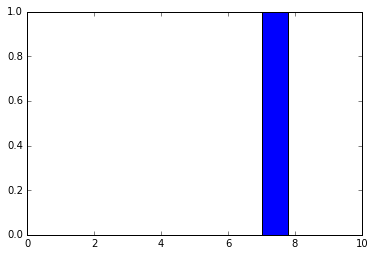

In [12]:
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

<Container object of 256 artists>

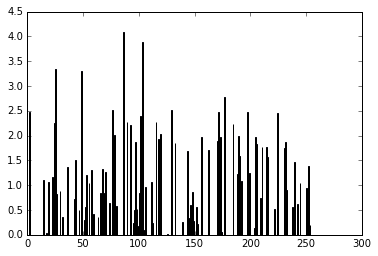

In [13]:
pred = f_dense(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())